In [1]:
from tensorflow.contrib.keras.python.keras.models import Sequential, Model
from tensorflow.contrib.keras.python.keras.layers.recurrent import SimpleRNN, LSTM, GRU
from tensorflow.contrib.keras.python.keras.layers.core import Dense, Dropout, Flatten
from tensorflow.contrib.keras.python.keras import layers
from tensorflow.contrib.keras.python.keras.layers import Input, Reshape, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D
from tensorflow.contrib.keras.python.keras.layers.wrappers import TimeDistributed

from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.contrib.keras.python.keras.optimizers import RMSprop, Adadelta, Adam

from tensorflow.contrib.keras.python.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.contrib.keras.python.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.contrib.keras.python.keras.models import load_model
from tensorflow.contrib.keras.python.keras.preprocessing import image

from tensorflow.contrib.keras.python.keras.layers.core import K
K.set_learning_phase(0)

import sys
import numpy as np
import os
import glob

import cv2

from IPython.display import clear_output

# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

import time
import pickle

In [2]:
# network
TRAIN = 1
n_classes = 7
# n_classes = 6
classes=np.array(('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'))
# classes=np.array(('angry', 'disgust', 'fear', 'neutral', 'sad', 'surprise'))

# data
REBUILD_DATA = 0
size = 224
video_length = 16
features_length = 2048

# training
PATH_TRAIN = 'E:/EmotiW2017/lstm/aligned/Train_AFEW_original'
NPY_X_TRAIN_DATA = 'training_data_x_resnet50_aligned_4_finetune_resnet.npy'
NPY_Y_TRAIN_DATA = 'training_data_y_resnet50_aligned_4_finetune_resnet.npy'

# validation
PATH_VAL = 'E:/EmotiW2017/lstm/aligned/Val_AFEW_original'
NPY_X_VAL_DATA = 'val_data_x_resnet50_aligned_4_finetune_resnet.npy'
NPY_Y_VAL_DATA = 'val_data_y_resnet50_aligned_4_finetune_resnet.npy'
# model
WEIGHT_FILE = 'resnet50_lstm_aligned_4_finetune_resnet.hdf5'
MODEL_FILE = 'resnet50_lstm_aligned_4_finetune_resnet.h5'
TRAINING_HIST = 'resnet50_lstm_aligned_4_finetune_resnet.pickle'

# Emotion to Integer Convertor

In [3]:
def emo2int(emo):
    if n_classes == 7:
        if emo == 'Angry':
            return 0
        elif emo == 'Disgust':
            return 1
        elif emo == 'Fear':
            return 2
        elif emo == 'Happy':
            return 3
        elif emo == 'Neutral':
            return 4
        elif emo == 'Sad':
            return 5
        else:
            return 6
    elif n_classes == 6:
        if emo == 'Angry':
            return 0
        elif emo == 'Disgust':
            return 1
        elif emo == 'Fear':
            return 2
        elif emo == 'Neutral':
            return 3
        elif emo == 'Sad':
            return 4
        else:
            return 5
    else:
        if emo == 'angry_happy_neutral':
            return 0
        else:
            return 1

# Confusion matrix

In [4]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Training Data
1. Count # of video in training data
2. Count # of frames in each video in training data
3. Generate training data

In [13]:
if REBUILD_DATA == 1:
    n_vids_train = 0

    for emo in os.listdir(PATH_TRAIN):
        full_emo = PATH_TRAIN + '/' + emo
        if os.path.isdir(full_emo):
            for vid in os.listdir(full_emo):
                full_vid = full_emo + '/' + vid

                n_vids_train += 1

    print(' > %d videos found' % (n_vids_train))

In [14]:
if REBUILD_DATA == 1:
    n_fra_stat_train = np.zeros((n_vids_train, 1))

    vid_indx = 0

    for emo in os.listdir(PATH_TRAIN):
        full_emo = PATH_TRAIN + '/' + emo
        if os.path.isdir(full_emo):
            for vid in os.listdir(full_emo):
                full_vid = full_emo + '/' + vid
                for fra in os.listdir(full_vid):
                    full_fra = full_vid + '/' + fra
                    if os.path.isfile(full_fra):
                        n_fra_stat_train[vid_indx, 0] += 1

                vid_indx += 1

    plt.hist(n_fra_stat_train, bins=60)
    plt.show()

> loading training data...done.
	shapes: (726, 16, 224, 224, 3), (726,)
	types:  int32, int32
	memory: 6670.125, 0.00276947021484375 MB
7 emotions found


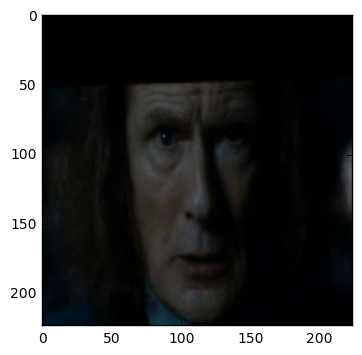

In [15]:
n_emos = 0
for emo in os.listdir(PATH_TRAIN):
    n_emos += 1

if REBUILD_DATA == 0 and os.path.isfile(NPY_X_TRAIN_DATA) and os.path.isfile(NPY_Y_TRAIN_DATA):
    print('> loading training data...', end='')
    X_train = np.load(NPY_X_TRAIN_DATA)
    y_train = np.load(NPY_Y_TRAIN_DATA)
    print('done.')
    
    # Visualization ***
    print('\tshapes: {}, {}'.format(X_train.shape, y_train.shape))
    print('\ttypes:  {}, {}'.format(X_train.dtype, y_train.dtype))
    print('\tmemory: {}, {} MB'.format(X_train.nbytes / 1048576, y_train.nbytes / 1048576))
    print('%d emotions found' % (n_emos))
else:
    # Visualization ***
    mode = '> generating training data'
    n_progress = n_vids_train
    
    X_train = []
    y_train = []

    X_train = np.zeros((n_vids_train, video_length, size, size, 3), dtype=np.int)

    vid_indx = 0
    
    n_emos = 0

    for emo in os.listdir(PATH_TRAIN):
        full_emo = PATH_TRAIN + '/' + emo
        n_emos += 1
        if os.path.isdir(full_emo):
            for vid in os.listdir(full_emo):
                full_vid = full_emo + '/' + vid

                # Initialize a training example of max_num_time_steps, im_size, im_size
                output = np.zeros((video_length, size, size, 3), dtype=np.int)

                # Decide how many images to put in that tensor
                numToAdd = int(np.min((video_length, n_fra_stat_train[vid_indx, 0])))

                # Sample that images
                fra_indx = 0
                example = np.zeros((numToAdd, size, size, 3), dtype=np.int)
                for fra in os.listdir(full_vid):
                    if fra_indx < numToAdd:
                        full_fra = full_vid + '/' + fra
                        if os.path.isfile(full_fra):
                            img = cv2.imread(full_fra)
                            img = cv2.resize(img, (size, size))
                            example[fra_indx] = img
                            
                            fra_indx += 1
                            
                            # Visualization ***
                            i_progress = vid_indx
                            sys.stdout.write('\r')
                            sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i_progress + 1) / n_progress - 1) + '>',
                                                                        int(100. * (i_progress + 1) / n_progress)))
                            sys.stdout.flush()
                    else:
                        break

                output[0:numToAdd, :, :, :] = example
                X_train[vid_indx, :, :, :, :] = output

                # Get the label for current video
                y_train.append(emo2int(emo))

                vid_indx += 1

    y_train = np.array(y_train)
    
    # Visualization ***
    sys.stdout.write('\r')
    sys.stdout.flush()

    # Visualization ***
    print(mode + ': OK')
    print('\tshapes: {}, {}'.format(X_train.shape, y_train.shape))
    print('\ttypes:  {}, {}'.format(X_train.dtype, y_train.dtype))
    print('\tmemory: {}, {} MB'.format(X_train.nbytes / 1048576, y_train.nbytes / 1048576))
    print('%d emotions found' % (n_emos))
    
    print('\n\n> saving generated data...', end='')
    np.save(NPY_X_TRAIN_DATA, X_train)
    np.save(NPY_Y_TRAIN_DATA, y_train)
    print('done.')

image = X_train[0, 0, :, :, :]
image = np.float32(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255
plt.imshow(image)
plt.show()

# Validation Data
1. Count # of video in training data
2. Count # of frames in each video in training data
3. Generate training data

In [16]:
n_vids_val = 0

for emo in os.listdir(PATH_VAL):
    full_emo = PATH_VAL + '/' + emo
    if os.path.isdir(full_emo):
        for vid in os.listdir(full_emo):
            full_vid = full_emo + '/' + vid
            
            n_vids_val += 1

print(' > %d videos found' % (n_vids_val))

 > 383 videos found


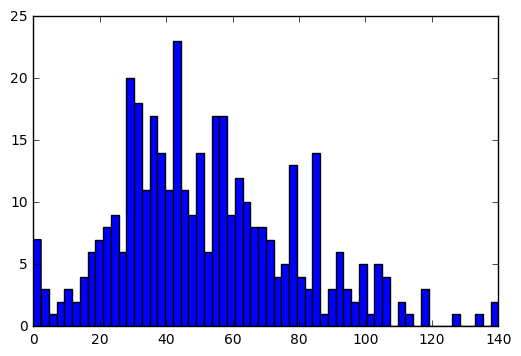

In [17]:
n_fra_stat_val = np.zeros((n_vids_val, 1))

vid_indx = 0

for emo in os.listdir(PATH_VAL):
    full_emo = PATH_VAL + '/' + emo
    if os.path.isdir(full_emo):
        for vid in os.listdir(full_emo):
            full_vid = full_emo + '/' + vid
            for fra in os.listdir(full_vid):
                full_fra = full_vid + '/' + fra
                if os.path.isfile(full_fra):
                    n_fra_stat_val[vid_indx, 0] += 1
                    
            vid_indx += 1

plt.hist(n_fra_stat_val, bins=60)
plt.show()

> loading validation data...done.
	shapes: (383, 16, 224, 224, 3), (383,)
	types:  int32, int32
	memory: 3518.8125, 0.001461029052734375 MB
7 emotions found


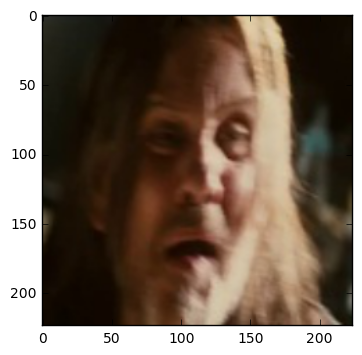

In [18]:
n_emos = 0
for emo in os.listdir(PATH_VAL):
    n_emos += 1

if REBUILD_DATA == 0 and os.path.isfile(NPY_X_VAL_DATA) and os.path.isfile(NPY_Y_VAL_DATA):
    print('> loading validation data...', end='')
    X_val = np.load(NPY_X_VAL_DATA)
    y_val = np.load(NPY_Y_VAL_DATA)
    print('done.')
    
    # Visualization ***
    print('\tshapes: {}, {}'.format(X_val.shape, y_val.shape))
    print('\ttypes:  {}, {}'.format(X_val.dtype, y_val.dtype))
    print('\tmemory: {}, {} MB'.format(X_val.nbytes / 1048576, y_val.nbytes / 1048576))
    print('%d emotions found' % (n_emos))
else:
    # Visualization ***
    mode = '> generating validation data'
    n_progress = n_vids_val
    
    X_val = []
    y_val = []

    X_val = np.zeros((n_vids_val, video_length, size, size, 3), dtype=np.int)

    vid_indx = 0
    
    n_emos = 0

    for emo in os.listdir(PATH_VAL):
        full_emo = PATH_VAL + '/' + emo
        n_emos += 1
        if os.path.isdir(full_emo):
            for vid in os.listdir(full_emo):
                full_vid = full_emo + '/' + vid

                # Initialize a testing example of max_num_time_steps, im_size, im_size
                output = np.zeros((video_length, size, size, 3), dtype=np.int)

                # Decide how many images to put in that tensor
                numToAdd = int(np.min((video_length, n_fra_stat_val[vid_indx, 0])))

                # Sample that images
                fra_indx = 0
                example = np.zeros((numToAdd, size, size, 3), dtype=np.int)
                for fra in os.listdir(full_vid):
                    if fra_indx < numToAdd:
                        full_fra = full_vid + '/' + fra
                        if os.path.isfile(full_fra):
                            img = cv2.imread(full_fra)
                            img = cv2.resize(img, (size, size))
                            example[fra_indx] = img

                            fra_indx += 1
                            
                            # Visualization ***
                            i_progress = vid_indx
                            sys.stdout.write('\r')
                            sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i_progress + 1) / n_progress - 1) + '>',
                                                                        int(100. * (i_progress + 1) / n_progress)))
                            sys.stdout.flush()
                    else:
                        break

                output[0:numToAdd, :, :, :] = example
                X_val[vid_indx, :, :, :, :] = output

                # Get the label for current video
                y_val.append(emo2int(emo))

                vid_indx += 1

    y_val = np.array(y_val)
    
    # Visualization ***
    sys.stdout.write('\r')
    sys.stdout.flush()

    # Visualization ***
    print(mode + ': OK')
    print('\tshapes: {}, {}'.format(X_val.shape, y_val.shape))
    print('\ttypes:  {}, {}'.format(X_val.dtype, y_val.dtype))
    print('\tmemory: {}, {} MB'.format(X_val.nbytes / 1048576, y_val.nbytes / 1048576))
    print('%d emotions found' % (n_emos))
    
    print('\n\n> saving generated data...', end='')
    np.save(NPY_X_VAL_DATA, X_val)
    np.save(NPY_Y_VAL_DATA, y_val)
    print('done.')
    
image = X_val[0, 0, :, :, :]
image = np.float32(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255
plt.imshow(image)
plt.show()

# ResNet + LSTM

In [5]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.

    Arguments:
      input_tensor: input tensor
      kernel_size: defualt 3, the kernel size of middle conv layer at main path
      filters: list of integers, the filterss of 3 conv layer at main path
      stage: integer, current stage label, used for generating layer names
      block: 'a','b'..., current block label, used for generating layer names

    Returns:
      Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = TimeDistributed(Conv2D(filters1, (1, 1), name=conv_name_base + '2a'))(input_tensor)
    x = TimeDistributed(BatchNormalization(axis=bn_axis, name=bn_name_base + '2a'))(x)
    x = TimeDistributed(Activation('relu'))(x)

    x = TimeDistributed(Conv2D(
        filters2, kernel_size, padding='same', name=conv_name_base + '2b'))(x)
    x = TimeDistributed(BatchNormalization(axis=bn_axis, name=bn_name_base + '2b'))(x)
    x = TimeDistributed(Activation('relu'))(x)

    x = TimeDistributed(Conv2D(filters3, (1, 1), name=conv_name_base + '2c'))(x)
    x = TimeDistributed(BatchNormalization(axis=bn_axis, name=bn_name_base + '2c'))(x)

    x = layers.add([x, input_tensor])
    x = TimeDistributed(Activation('relu'))(x)
    
    return x

In [6]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut.

    Arguments:
      input_tensor: input tensor
      kernel_size: defualt 3, the kernel size of middle conv layer at main path
      filters: list of integers, the filterss of 3 conv layer at main path
      stage: integer, current stage label, used for generating layer names
      block: 'a','b'..., current block label, used for generating layer names
      strides: Tuple of integers.

    Returns:
      Output tensor for the block.

    Note that from stage 3, the first conv layer at main path is with
    strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = TimeDistributed(Conv2D(
        filters1, (1, 1), strides=strides,
        name=conv_name_base + '2a'))(input_tensor)
    x = TimeDistributed(BatchNormalization(axis=bn_axis, name=bn_name_base + '2a'))(x)
    x = TimeDistributed(Activation('relu'))(x)

    x = TimeDistributed(Conv2D(
        filters2, kernel_size, padding='same', name=conv_name_base + '2b'))(x)
    x = TimeDistributed(BatchNormalization(axis=bn_axis, name=bn_name_base + '2b'))(x)
    x = TimeDistributed(Activation('relu'))(x)

    x = TimeDistributed(Conv2D(filters3, (1, 1), name=conv_name_base + '2c'))(x)
    x = TimeDistributed(BatchNormalization(axis=bn_axis, name=bn_name_base + '2c'))(x)

    shortcut = TimeDistributed(Conv2D(
        filters3, (1, 1), strides=strides,
        name=conv_name_base + '1'))(input_tensor)
    shortcut = TimeDistributed(BatchNormalization(axis=bn_axis, name=bn_name_base + '1'))(shortcut)

    x = layers.add([x, shortcut])
    x = TimeDistributed(Activation('relu'))(x)
    
    return x

### Time-seried ResNet

In [19]:
print(' > Declaring time-seried ResNet...', end='')
bn_axis = 3
img_input = Input(shape=(video_length, 224, 224, 3))

x = TimeDistributed(ZeroPadding2D((3, 3)))(img_input)
x = TimeDistributed(Conv2D(64, (7, 7), strides=(2, 2), name='conv1'))(x)
x = TimeDistributed(BatchNormalization(axis=bn_axis, name='bn_conv1'))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(MaxPooling2D((3, 3), strides=(2, 2)))(x)

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

x = TimeDistributed(AveragePooling2D((7, 7), name='avg_pool'))(x)

x = TimeDistributed(Flatten())(x)

# Create base model (ResNet)
base_model = Model(img_input, x, name='resnet50_lstm')

# Load ImageNet weights
weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model.load_weights(weights_path)

print('done.')

 > Declaring time-seried ResNet...done.


### LSTM with ResNet

In [20]:
print('> Creating lstm model based on ResNet...', end='')

xx = base_model.output

xx = LSTM(128, input_shape=(video_length, features_length), dropout=0.5, return_sequences=False)(xx)
xx = Dense(256, activation='relu')(xx)
xx = Dropout(0.5)(xx)
xx = Dense(256, activation='relu')(xx)
xx = Dropout(0.5)(xx)
xx = Dense(n_classes, activation='softmax')(xx)

# Freeze base model's layers (timedistributed layers)
for layer in base_model.layers:
    if hasattr(layer, 'layer'):
        layer.layer.trainable = False
    layer.trainable = False
    
# Create model.
lstm = Model(base_model.input, xx, name='resnet50_lstm')

print('done.')

> Creating lstm model based on ResNet...done.


### Compile defined model

In [25]:
learning_rate = 0.0001
dc = 10**-6
early_stop_after = 50


early_stopping = EarlyStopping(monitor='val_acc', patience=early_stop_after, verbose=1)
checkpointer = ModelCheckpoint(monitor='val_acc', filepath='checkpoints/resnet_lstm_finetune' + '_' + str(size) + '_model.{epoch:05d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.hdf5', verbose=1, save_best_only=True)

# opt = Adam(lr=learning_rate)
opt = RMSprop(lr=learning_rate, decay=dc)
lstm.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

for layer in base_model.layers:
    layer.trainable = False
    
print(lstm.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 16, 224, 224,  0                                            
____________________________________________________________________________________________________
time_distributed_319 (TimeDistri (None, 16, 230, 230,  0                                            
____________________________________________________________________________________________________
time_distributed_320 (TimeDistri (None, 16, 112, 112,  9472                                         
____________________________________________________________________________________________________
time_distributed_321 (TimeDistri (None, 16, 112, 112,  256                                          
___________________________________________________________________________________________

# Training

In [29]:
if TRAIN == 1:
    batch_size = 24
    n_epochs = 10000

    start_time = time.time()
    
    train_history = lstm.fit(X_train, y_train,
                             validation_data=(X_val, y_val),
                             shuffle=True, batch_size=batch_size,
                             epochs=n_epochs,
                             verbose=1,
                             callbacks=[checkpointer, early_stopping])
    
    training_time = time.time() - start_time
    print('> Training time: ' + str(training_time) + ' sec')

Train on 726 samples, validate on 383 samples
Epoch 1/10000
726/726 [==============================] - 92s - loss: 1.8569 - acc: 0.2727 - val_loss: 1.8851 - val_acc: 0.2585
Epoch 2/10000
726/726 [==============================] - 72s - loss: 1.7647 - acc: 0.3499 - val_loss: 1.8527 - val_acc: 0.2742
Epoch 3/10000
726/726 [==============================] - 71s - loss: 1.6657 - acc: 0.4077 - val_loss: 1.8365 - val_acc: 0.2898
Epoch 4/10000
726/726 [==============================] - 71s - loss: 1.5499 - acc: 0.4573 - val_loss: 1.8329 - val_acc: 0.3029
Epoch 5/10000
726/726 [==============================] - 70s - loss: 1.4523 - acc: 0.4904 - val_loss: 1.8769 - val_acc: 0.2872
Epoch 6/10000
726/726 [==============================] - 70s - loss: 1.3141 - acc: 0.5771 - val_loss: 1.7978 - val_acc: 0.2768
Epoch 7/10000
726/726 [==============================] - 70s - loss: 1.2139 - acc: 0.6281 - val_loss: 1.8475 - val_acc: 0.2663
Epoch 8/10000
726/726 [==============================] - 70s - lo

726/726 [==============================] - 71s - loss: 0.0026 - acc: 1.0000 - val_loss: 3.6334 - val_acc: 0.2507
Epoch 33/10000
726/726 [==============================] - 90s - loss: 0.0227 - acc: 0.9959 - val_loss: 3.6341 - val_acc: 0.2820
Epoch 34/10000
726/726 [==============================] - 69s - loss: 0.0018 - acc: 1.0000 - val_loss: 3.7546 - val_acc: 0.2768
Epoch 35/10000
726/726 [==============================] - 69s - loss: 0.0015 - acc: 1.0000 - val_loss: 4.1055 - val_acc: 0.2454
Epoch 36/10000
726/726 [==============================] - 69s - loss: 0.0365 - acc: 0.9917 - val_loss: 3.9743 - val_acc: 0.2663
Epoch 37/10000
726/726 [==============================] - 69s - loss: 0.0010 - acc: 1.0000 - val_loss: 4.0065 - val_acc: 0.2637
Epoch 38/10000
726/726 [==============================] - 69s - loss: 6.1272e-04 - acc: 1.0000 - val_loss: 4.1928 - val_acc: 0.2794
Epoch 39/10000
726/726 [==============================] - 69s - loss: 0.0339 - acc: 0.9904 - val_loss: 4.0373 - val

# Save model OR Load trained model

In [30]:
if TRAIN == 1:
    print('> Saving trained model...', end='')
    # Save trained model
    lstm.save_weights(WEIGHT_FILE)
    lstm.save(MODEL_FILE)
    # Save training history
    with open(TRAINING_HIST, 'wb') as f:
        pickle.dump(train_history.history, f)
        
    history_ = train_history.history
    print('done.')
else:
    print('> Loading trained model...', end='')
    # Load trained model
    lstm.load_weights(WEIGHT_FILE)
#     lstm = load_model(MODEL_FILE)
    
    # Load training history
    file = open(TRAINING_HIST, 'rb')
    history_ = pickle.load(file)
    print('done.')

> Saving trained model...done.


In [31]:
# Get the latest weight file based on last modified time
lowf = glob.glob('./checkpoints/*.hdf5')
BEST_WEIGHT_FILE = max(lowf, key=os.path.getmtime)
print(BEST_WEIGHT_FILE)

./checkpoints\resnet_lstm_finetune_224_model.00011-0.6577-0.8416-1.9465-0.3107.hdf5


In [32]:
print('> loading trained model...', end='')
# Load trained model
# lstm = load_model(BEST_WEIGHT_FILE)
lstm.load_weights(BEST_WEIGHT_FILE)

# Load training history
file = open(TRAINING_HIST, 'rb')
history_ = pickle.load(file)
print('done.')

> loading trained model...done.


# Validate model again!

In [ ]:
score = lstm.evaluate(X_train, y_train, batch_size=batch_size)
print('Train score:', score[0])
print('Train accuracy:', score[1])

score = lstm.evaluate(X_val, y_val, batch_size=batch_size)
print('Val score:', score[0])
print('Val accuracy:', score[1])

120/726 [===>..........................] - ETA: 38s

# Confusion matrix

In [ ]:
y_pred_training_ = lstm.predict(x=X_train, batch_size=batch_size, verbose=1)
y_pred_ = lstm.predict(x=X_val, batch_size=batch_size, verbose=1)

# Saving scores

### Validation

In [ ]:
# Count # of videos
n_vids_val = 0

PATH_VAL_CSV = 'E:/EmotiW2017/lstm/aligned/Val_AFEW_original_scores'

for emo in os.listdir(PATH_VAL):
    full_emo = PATH_VAL + '/' + emo
    if os.path.isdir(full_emo):
        for vid in os.listdir(full_emo):
            n_vids_val += 1

# Read images and extract features
vid_indx = 0

val_names = []

for emo in os.listdir(PATH_VAL):
    full_emo = PATH_VAL + '/' + emo
    if os.path.isdir(full_emo):
        for vid in os.listdir(full_emo):
            full_vid = PATH_VAL_CSV + '/' + emo + '/' + vid
            
            full_vid = full_vid[:-14] + 'csv'

            # Get the name for current video
            val_names.append(full_vid)

            vid_indx += 1

# val_names

In [ ]:
name_indx = 0
cor_pred = 0

for val_f_name in val_names:
    val_scores = y_pred_[name_indx, :]
    cor_pred += (np.argmax(y_pred_[name_indx, :]) == y_val[name_indx])
    
    np.savetxt(val_f_name, val_scores)
    
    name_indx += 1
    
cor_pred/len(y_val)

### Training

In [ ]:
# Count # of videos
n_vids_train = 0

PATH_TRAIN_CSV = 'E:/EmotiW2017/lstm/aligned/Train_AFEW_original_scores'

for emo in os.listdir(PATH_TRAIN):
    full_emo = PATH_TRAIN + '/' + emo
    if os.path.isdir(full_emo):
        for vid in os.listdir(full_emo):
            n_vids_train += 1

# Read images and extract features
vid_indx = 0

train_names = []

for emo in os.listdir(PATH_TRAIN):
    full_emo = PATH_TRAIN + '/' + emo
    if os.path.isdir(full_emo):
        for vid in os.listdir(full_emo):
            full_vid = PATH_TRAIN_CSV + '/' + emo + '/' + vid
            
            full_vid = full_vid[:-14] + 'csv'

            # Get the name for current video
            train_names.append(full_vid)

            vid_indx += 1

# train_names

In [ ]:
name_indx = 0
cor_pred = 0

for train_f_name in train_names:
    train_scores = y_pred_training_[name_indx, :]
    cor_pred += (np.argmax(y_pred_training_[name_indx, :]) == y_train[name_indx])
    
    np.savetxt(train_f_name, train_scores)
    
    name_indx += 1
        
cor_pred/len(y_train)

In [ ]:
y_pred_training = np.argmax(y_pred_training_, axis=1)
y_pred = np.argmax(y_pred_, axis=1)

plot_confusion_matrix(y_test=y_train, y_pred=y_pred_training,
                      classes=classes,
                      normalize=True,
                      title='Normalized confusion matrix - training dataset',
                      cmap=plt.cm.Reds)

plot_confusion_matrix(y_test=y_val, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      title='Normalized confusion matrix - validation dataset')

plot_confusion_matrix(y_test=y_val, y_pred=y_pred,
                      classes=classes,
                      normalize=False,
                      title='Unnormalized confusion matrix - validation dataset')

np.sum(y_pred == y_val)/len(y_val)

# Training history

In [ ]:
# list all data in history
print(history_.keys())
# summarize history for accuracy
plt.plot(history_['acc'])
plt.plot(history_['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_['loss'])
plt.plot(history_['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()